#### _Speech Processing Labs 2020: SIGNALS 2: Moving Average as Rectangular Filter_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

from dspMisc import *

# The Moving Average Filter as a Rectangular Filter

<div class="alert alert-success">
<em>This notebook illustrates how we can use the convolution theorem understand why the moving average type filters act like low pass filters, and also the connection with leakage in the DFT magnitude response we saw previously.  <b>This is optional extension material</b>. 
    
If you want to see an example of the convolution theorem working in the frequency domain, you can just run the code and have a look at the graph at the end entitled 'Frequency response after applying 5-point weighted average filter'</em>
</div>

### Learning Outcomes
* Understand how the moving average filter relates to a rectangular FIR filter

### Need to know
* Topic Videos: Spectral Envelope, Filter, Impulse Train
* [FIR filters](./signals-2-2-fir-filters.ipynb)

<div class="alert alert-warning">
<strong>Equation alert</strong>: If you're viewing this on github, please note that the equation rendering is not always perfect. You should view the notebooks through a jupyter notebook server for an accurate view.
</div>


The convolution theorem tells us that, if we know the frequency response of an FIR filter, we know how it will affect the frequency response of it's input (we just multiply the individual frequency response together). 

To understand what filter frequency response will look like, it's helpful to first observe that our unweighted moving average filter is pretty much a rectangular window function.  It's easy to see what this means when we plot it. The following function allows us to generate rectangular functions:

In [2]:
def gen_rect_window(start_index, end_index, sample_rate=64, seq_length=64): 
    nsteps = np.array(range(seq_length))
    t_s = 1/sample_rate
    time_steps = t_s * nsteps

    ## Let's make a rectangular window
    x_rect = np.zeros(seq_length)
    x_rect[start_index:end_index] = 1
    
    return x_rect, time_steps


## A noisy sample

As an example, let's make a noisy sample `x_noisy`.  This is made up of 4 Hz and 24 Hz cosine functions, which a sampling rate of `f_s=64` Hz.  We take `N=64` samples as input.   

sampling rate: f_s = 64.000000
sampling time: t_s: 0.015625


Text(0, 0.5, 'Amplitude')

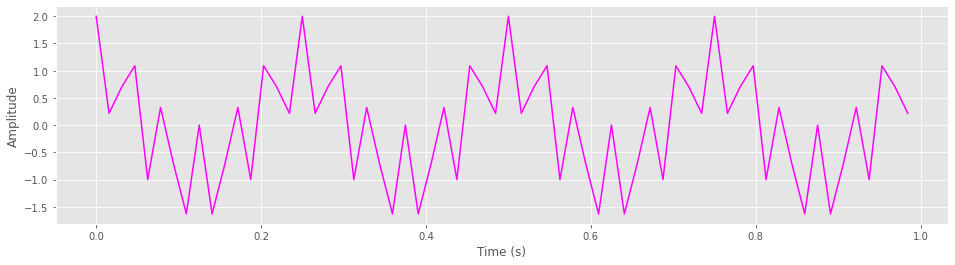

In [3]:
## Set the number of samples N, sampling rate f_s (hence sampling time t_s)
N=64
f_s = 64
t_s = 1/f_s

print("sampling rate: f_s = %f\nsampling time: t_s: %f" % (f_s, t_s))

## make some sinusoids: 
## Since the sample rate and sequence length is the same, the generated time steps will match for 
## x1 and x2
x1, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=24, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

# add them up!
x_noisy = x1 + x2

## Plot the compound sinusoid we've just created:
fig, timedom = plt.subplots(figsize=(16, 4))
timedom.plot(time_steps, x_noisy, color='magenta')
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')

### Apply a moving average filter to this input 


Text(0, 0.5, 'Amplitude')

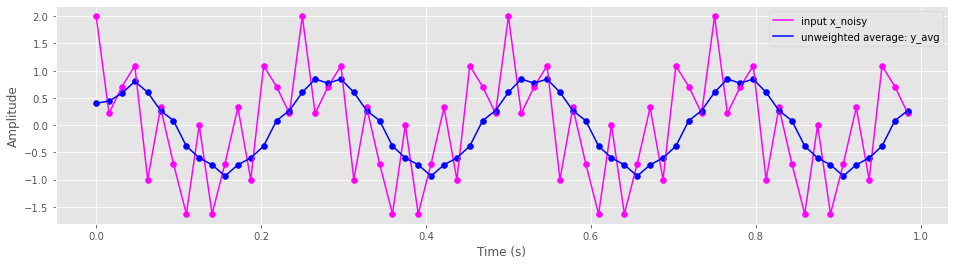

In [8]:
## The 5-point moving average coefficients
h_avg = np.array([1/5, 1/5, 1/5, 1/5, 1/5])

## Apply this to x_noisy
y_avg = fir_filter(x_noisy, h_avg)

## Plot the filter outputs
fig, timedom = plt.subplots(figsize=(16, 4))

## The original "noisy" input
timedom.plot(time_steps, x_noisy, color='magenta', label='input x_noisy')
timedom.scatter(time_steps, x_noisy, color='magenta')

## The 5-point moving average
timedom.plot(time_steps, y_avg, color='blue', label='unweighted average: y_avg')
timedom.scatter(time_steps, y_avg, color='blue')
timedom.legend()
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')

###  Now, we make a rectangular window

Text(0.5, 1.0, 'a rectangular window')

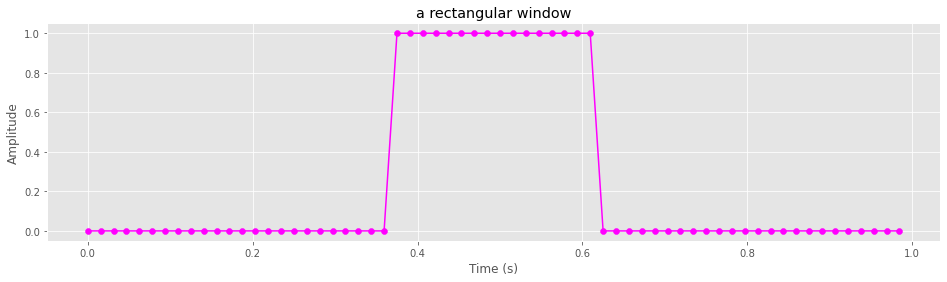

In [9]:
## Make rectangular window
N=64
K=16
f_s=64
start_index=24
end_index=start_index+K

x_rect, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N)

fig, timedom = plt.subplots(figsize=(16, 4))
timedom.scatter(time_steps, x_rect, color='magenta')
timedom.plot(time_steps, x_rect, color='magenta')
timedom.set_xlabel('Time (s)')
timedom.set_ylabel('Amplitude')
timedom.set_title('a rectangular window')

You should see a sequence with 64 point where the mmiddle 16 points have value 1 and the rest have value 0  (i.e., it looks like a rectangle in the middle).

### Now, let's  look at the frequency response of the rectangular window

Text(0.5, 1.0, 'Frequency response of rectangular window')

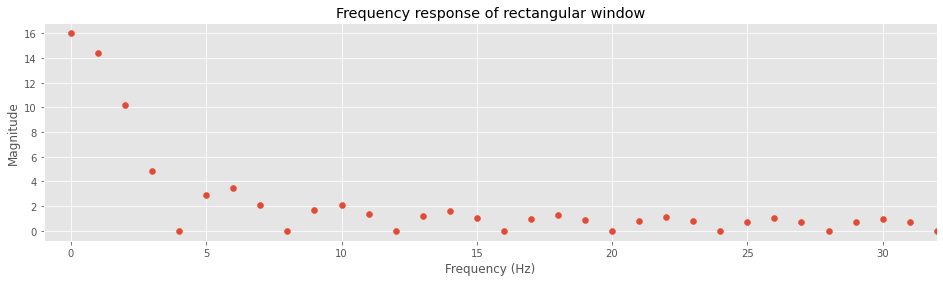

In [10]:
## Now we do the DFT on the rectangular function:

## get the magnitudes and phases
mags_rect, phases_rect = get_dft_mag_phase(x_rect, N)

## the DFT output frequencies
dft_freqs_rect = get_dft_freqs_all(f_s, N)

## let's just look at the magnitudes
fig, fdom = plt.subplots(figsize=(16, 4))
fdom.set(xlim=(-1, N/2))
fdom.scatter(dft_freqs_rect, mags_rect)
fdom.set_xlabel("Frequency (Hz)")
fdom.set_ylabel('Magnitude')
fdom.set_title('Frequency response of rectangular window')
## Looks leaky! 

### Leaky windows? 

The plot of the frequency magnitude response of our rectangular window has the hallmarks of leakiness. That is, the frequency response looks scalloped, with the biggest peak occuring around 0Hz. That is, it looks like a low pass filter!  

With a bit of algebra we can derive the frequency for any $m$ (not just the DFT output bins indices) to be the following:  

If $x[n]$ is a rectangular function of N samples with $K$ continugous samples of value 1 (starting at index $n_0$), we can figure out what the DFT output will be:

$$X[m] = e^{i(2\pi m/N)(n_0-(K-1)/2)} . \frac{\sin(2\pi mK/2N)}{\sin(2\pi m /2N)}$$

This is called the **Dirichlet kernel**. It has the **sinc** shape we saw when we looked at spectral leakage. 

How is this useful?  Since we know what the frequency response of a rectangular window is, we know what convolving this with different input sequences will look like in the frequency domain.  We just multiply the frequency magnitude responses together. 

<div class="alert alert-success">
On a more general note, this sort of convolution with a (short) window is how we do frequency analysis of speech: we taking windows of speech (aka frames) through time and and apply the DFT to get a frequency response.  A rectangular window is the simplest type of window we can take.  The equation above tells us that the sinc shaped response is an inherent part of using this sort of window.  In fact, we can use other window types (e.g. Hanning) to make the main lobes shaper and the sidelobes flatter, but we never really get away from this sinc shape in real world applications.  This is a key component of this soft of <strong>short term analysis</strong>.  

  </div>

Let's write this up in a function: 

In [11]:
def gen_rect_response(n_0, K, N, stepsize=0.01, polar=True, amplitude=1):
    ms = np.arange(0.01, N, stepsize)
    qs = 2*np.pi*ms/N 

    ## Infact, we can work the frequency response to be the Dirichlet Kernel:
    response = (np.exp(-1j*qs*(n_0-(K-1)/2)) * np.sin(qs*K/2))/np.sin(qs/2) 
    
    if polar: 
        response_polar = [cmath.polar(z) for z in response]
        mags = np.array([m for m, _ in response_polar]) * amplitude
        phases = np.array([ph if round(mag) > 0 else 0 for mag, ph in response_polar])
        return (mags, phases, ms)
        
    return response, ms
    

Now we can plot the dirichlet kernel with the leaky looking DFT magnitudes we calculated earlier for our rectangular window.  

Text(0.5, 1.0, 'Frequency response of a rectangular sequence, 64 samples with 16 contiguous ones')

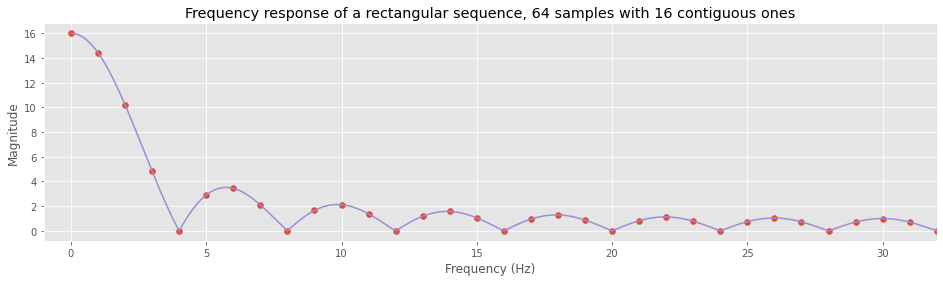

In [12]:
## Overlay the dirichlet kernel onto the DFT magnitudes we calculated earlier
## You should be able to see that the DFT magnitudes appear as discrete samples of the Dirichlet Kernel

mags_rect, phases_rect = get_dft_mag_phase(x_rect, N)
mags_rect_sinc , _ , ms = response = gen_rect_response(start_index, K, N)

fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(dft_freqs_rect, mags_rect, label='rectangular window')
ax.plot((f_s/N)*ms, mags_rect_sinc, color='C2', label='dirichlet')
ax.set(xlim=(-1,N/2))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency response of a rectangular sequence, %d samples with %d contiguous ones' % (N, K))

You should be able to see that the DFT magnitudes appear as discrete samples of the sinc shaped Dirichlet Kernel




### The unweighted average filter as a rectangular function

We can think of our 5-point unweighted average filter as a 5-point input sequence with all values set to 1/5.  We can then deduce that the frequency response of the filter will have the same shape as the frequency response of a rectangular window of all ones, but scaled down by 1/5.  

Now let's check: 

h_avg: [0.2 0.2 0.2 0.2 0.2]


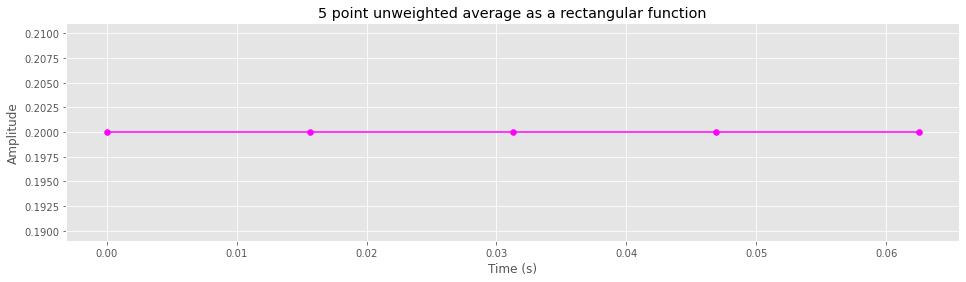

In [13]:
N_h=5 
f_s=64
start_index=0
end_index=N_h - start_index

## A 5 point rectangular window of all ones
h_avg, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N_h)
h_avg = h_avg/N_h

fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, h_avg, color='magenta')
td.plot(time_steps, h_avg, color='magenta')
td.set_xlabel('Time (s)')
td.set_ylabel('Amplitude')
td.set_title('5 point unweighted average as a rectangular function')

## Not very exciting looking! 
print("h_avg:", h_avg)

You should just see 5 point in a row, all with value 1/5.  Now, we can plot the DFT magnitude response, as well as it's idealized continuous version: 

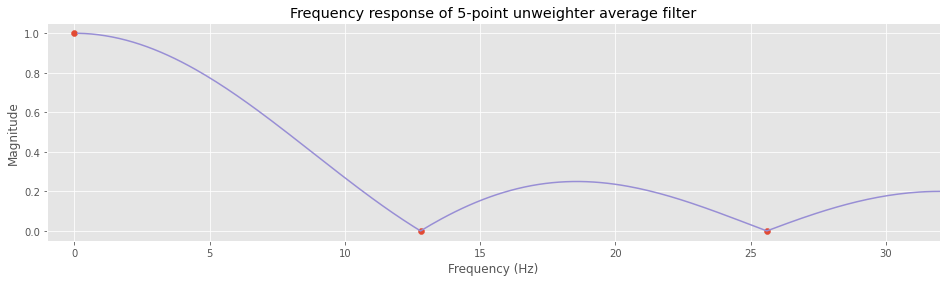

In [14]:
## Get the frequency magnitude response for our rectangular function
mags_h_avg, phases_h_avg = get_dft_mag_phase(h_avg, N_h)

## Get the continuous 
rect_mags_h_avg, _ , ms = gen_rect_response(start_index, N_h, N_h, amplitude=np.max(h_avg)) 


## x-axis as frequencies rather than indices
ms_freqs_h_avg = (f_s/N_h) * ms
dft_freqs_h_avg = (f_s/N_h) * np.arange(N_h)

## Plot the frequency magnitude response
fig, fd = plt.subplots(figsize=(16, 4))
fd.set(xlim=(-1, N/2))
fd.scatter(dft_freqs_h_avg, mags_h_avg)
fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Frequency response of 5-point unweighter average filter')
#fd.scatter(dft_freqs_rect, mags_rect)

fd.plot(ms_freqs_h_avg, rect_mags_h_avg, color="C2")

You should see $floor(N/2) = 2$ points, with a main lobe peaking at 0 Hz, and side lobes peaking between each of the DFT output frequencies.  
So,  DFT frequencies sit exactly at the zeros of this function when the windown size K is the same as the number of samples. 


### Matching the filter and input size with zero padding

The theorem we saw above told us that we could calculate the frequency response of applying the FIR filter to an input sequence (via convolution), but multiply the DFT outputs of the filter and the input sequence.  

Now, the x-axis range matches our that of our noisy input sequence because that is determined by the sampling rate. However, the filter frequency response we have above only has 5 outputs, while our input sample size was 64 because the number of DFT outputs is determined by the number of samples we put into the DFT.  

To get things in the right form, we need to do some **zero padding** of the filter. We'll see that this basically gives us more samples of the Dirichlet Kernel corresponding to the filter frequency response. 



Text(0.5, 1.0, '5 point unweighted average FIR filter padded with zeros')

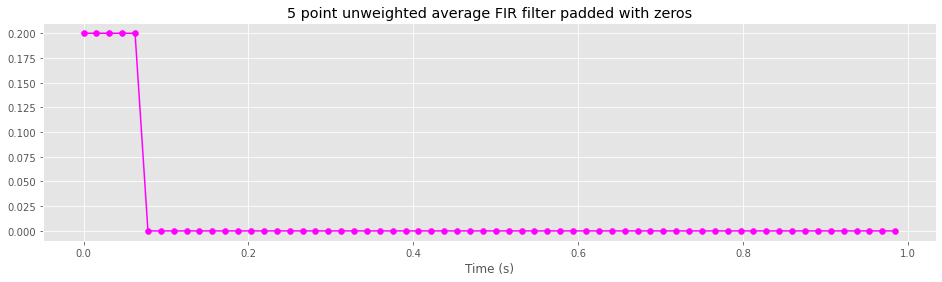

In [15]:
N=64
K=5
f_s=64
start_index=0
end_index=K

## Make a rectangular filter: K ones at the start
h_avg_pad, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N)

## Divide by K to make it an average
h_avg_pad = h_avg_pad/K

## Plot the filter
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, h_avg_pad, color='magenta')
td.plot(time_steps, h_avg_pad, color='magenta')
td.set_xlabel('Time (s)')
td.set_title('5 point unweighted average FIR filter padded with zeros')

#print("N=%d, K=%d, start=%d, end=%d" % (N, K, start_index, end_index))




Text(0.5, 1.0, 'Magnitude response of 5-point unweighter average filter zero padded to 64 samples')

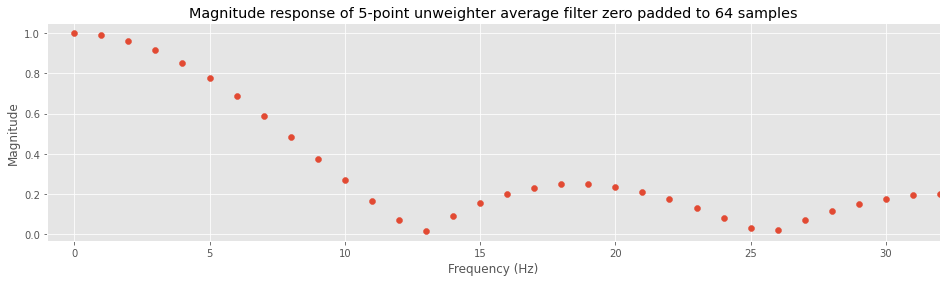

In [16]:
## Get the frequency magnitude response for our rectangular function
mags_havg, phases_havg = get_dft_mag_phase(h_avg_pad, N)

## Plot the frequency magnitude response 
## x-axis as actual frequencies rather that DFT indices
dft_freqs_havg = (f_s/N) * np.arange(N)

fig, fd = plt.subplots(figsize=(16, 4))
fd.set(xlim=(-1,N/2))
fd.scatter(dft_freqs_havg, mags_havg)
fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Magnitude response of 5-point unweighter average filter zero padded to 64 samples')

You should be able to see more clearly in the frequency response graph that the zero padding doesn't change doesnt change the basic shape of the filter's frequency response, we just get a finer grained representation in terms of samples (red dots). 

### Calculate the input and filter frequency responses

In [17]:
## Now let's calculate frequency responses of the original input
mags, phases = get_dft_mag_phase(x_noisy, N)

## ...  the filter
mags_filter, phases_filter = get_dft_mag_phase(h_avg_pad, N)

## ... and the filtered output that we calculated above
mags_avg, phases_avg = get_dft_mag_phase(y_avg, N)

## Plot with actual frequencies on the x-axis
dft_freqs = get_dft_freqs_all(f_s, N)

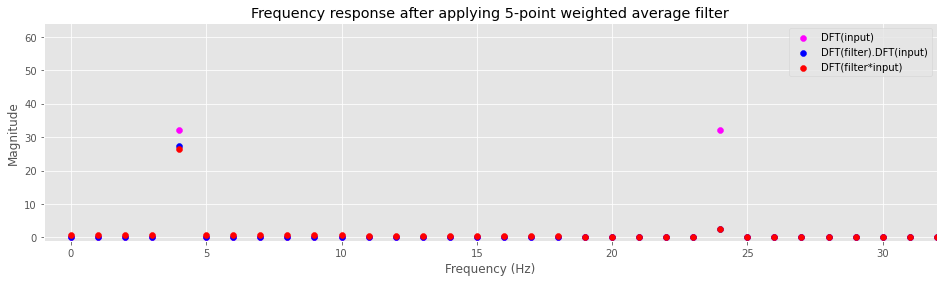

In [18]:
## plot frequency responses

fig, fd = plt.subplots(figsize=(16, 4))
fd.set(xlim=(-1,N/2), ylim=(-1, N))

# DFT(input)
fd.scatter(dft_freqs, mags, color='magenta', label='DFT(input)')

# DFT(filter) * DFT(input)
fd.scatter(dft_freqs, mags_filter*mags, color='blue', label='DFT(filter).DFT(input)')

# DFT(filtered input)
fd.scatter(dft_freqs, mags_avg, color='red', label='DFT(filter*input)')
fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Frequency response after applying 5-point weighted average filter')
fd.legend()

You should see that the results from multiplying the DFT magnitudes from the input and the filter (blue) is (more or less) the same as the DFT of applying the filter in th time domain via convolution (red)

* Notice that there are some differences between the results from the time domain application of the filter (red) and the frequency domain multiplication (blue).  In particular there appears to be some leakage in the time-domain convolution case, possibly due to floating point errors.

### Exercise

* Try changing the frequency of the second cosine component of our compound wave in the code below. 
    * Does the amount of attenuation of the high frequency component change as suggested by the DFT of the filter? 
    * e.g. try 26 Hz vs 19 Hz
* What does this tell you about how well this low pass filter get's rid of high frequency noise?



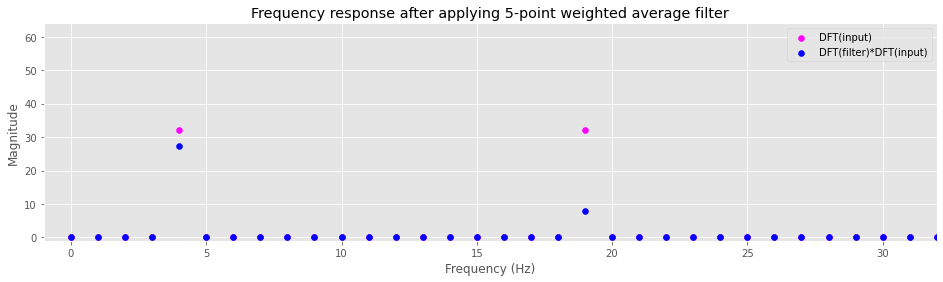

In [19]:
## Change the frequency of x2

x1, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=19, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

# add them up!
x_noisy = x1 + x2

## Now let's calculate frequency responses of the original input
mags, phases = get_dft_mag_phase(x_noisy, N)

## ...  the filter
mags_filter, phases_filter = get_dft_mag_phase(h_avg_pad, N)

## Plot with actual frequencies on the x-axis
dft_freqs = get_dft_freqs_all(f_s, N)

## plot frequency responses

fig, fd = plt.subplots(figsize=(16, 4))

fd.set(xlim=(-1,N/2), ylim=(-1, N))


# DFT(input)
fd.scatter(dft_freqs, mags, color='magenta', label='DFT(input)')

# DFT(filter) * DFT(input)
fd.scatter(dft_freqs, mags_filter*mags, color='blue', label='DFT(filter)*DFT(input)')

fd.set_xlabel('Frequency (Hz)')
fd.set_ylabel('Magnitude')
fd.set_title('Frequency response after applying 5-point weighted average filter')
fd.legend()

### Notes